In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

## Travel time prediction

In [2]:
data = pd.read_csv('../dataPreprocessing/data/data.csv', low_memory=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636659 entries, 0 to 1636658
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   vehicle_id         1636659 non-null  int64  
 1   line_id            1636659 non-null  int64  
 2   datetime           1636659 non-null  object 
 3   station_id         1636659 non-null  int64  
 4   vehicle_type       1636659 non-null  float64
 5   sequence_id        1636659 non-null  object 
 6   order              1636659 non-null  int64  
 7   line_label         1636659 non-null  object 
 8   datetime_diff      1636659 non-null  float64
 9   outlier            1636659 non-null  int64  
 10  hour               1636659 non-null  int64  
 11  quarter            1636659 non-null  int64  
 12  weekday            1636659 non-null  int64  
 13  service_class      1636659 non-null  int64  
 14  Temperature        1427264 non-null  float64
 15  Precipitation      1427639 non-n

In [4]:
#split data
data.datetime = data.datetime.apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H'))
data = data.sort_values(['datetime','sequence_id'])

In [5]:
data.shape

(1636659, 23)

In [6]:
#fillna 
data.fillna(-1, inplace=True)

In [7]:
#train test split
test_seq_count = round(data.sequence_id.nunique() * 0.3)
test_sequences = pd.Series(data.sequence_id.unique()).tail(test_seq_count).values

In [8]:
train = data[~data.sequence_id.isin(test_sequences)]
test  = data[data.sequence_id.isin(test_sequences)]

In [9]:
X_train = data[~data.sequence_id.isin(test_sequences)].drop(['datetime_diff', 'outlier', 'datetime'], axis=1)
y_train  = data[~data.sequence_id.isin(test_sequences)].datetime_diff

X_test  = data[data.sequence_id.isin(test_sequences)].drop(['datetime_diff', 'outlier', 'datetime'], axis=1)
y_test  = data[data.sequence_id.isin(test_sequences)].datetime_diff

In [ ]:
plt.figure(figsize=(15,5))
X_train.groupby('line_label').sequence_id.count().plot(kind = 'bar')
plt.plot(np.arange(31), np.ones(31)*1000, 'r--')
plt.title('train data')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
X_test.groupby('line_label').sequence_id.count().plot(kind = 'bar')
plt.plot(np.arange(31), np.ones(31)*1000, 'r--')
plt.title('test data')
plt.show()

In [37]:
#scale data
#min max scaler
from pickle import dump
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

scaler = MinMaxScaler()
encoder = LabelEncoder()

encoder.fit(data[['line_label']])
X_train.line_label = encoder.transform(X_train.line_label)
X_test.line_label  = encoder.transform(X_test.line_label)

C:\Users\Aziz\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [38]:
X_train = X_train.drop('sequence_id', axis=1).values
X_test = X_test.drop('sequence_id', axis=1).values

In [39]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [40]:
X_train.shape

(919349, 19)

In [41]:
X_test.shape

(717310, 19)

In [42]:
y_train = y_train.values.reshape(-1,1)
y_test  = y_test.values.reshape(-1,1)

In [43]:
X_train = X_train.reshape(-1,1,19)
X_test = X_test.reshape(-1,1,19)

In [44]:
X_train.shape

(919349, 1, 19)

In [45]:
X_test.shape

(717310, 1, 19)

In [46]:
y_train.shape

(919349, 1)

In [47]:
y_test.shape

(717310, 1)

## LSTM one to one

In [9]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, RNN, GRU, LSTM, Dropout
from tensorflow.keras.losses import MAE, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

In [10]:
model = Sequential()
model.add(LSTM(units=128,  activation='relu', input_shape=(1,19),return_sequences = True))
model.add(LSTM(units=128,  activation='relu', input_shape=(1,19),return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            75776     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

In [11]:
optimizer = Adam(lr=0.001)
loss = MeanSquaredError()
metric = RootMeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [57]:
model.fit(X_train, y_train, epochs=10, batch_size=124, shuffle=False,
         callbacks=[EarlyStopping(restore_best_weights=True, patience=3, monitor='root_mean_squared_error')])

Epoch 1/10
7415/7415 [==============================] - 47s 6ms/step - loss: 10816.6238 - root_mean_squared_error: 103.2917
Epoch 2/10
7415/7415 [==============================] - 45s 6ms/step - loss: 7702.2246 - root_mean_squared_error: 87.6832
Epoch 3/10
7415/7415 [==============================] - 44s 6ms/step - loss: 7225.0720 - root_mean_squared_error: 84.8554
Epoch 4/10
7415/7415 [==============================] - 44s 6ms/step - loss: 6189.7251 - root_mean_squared_error: 78.6193
Epoch 5/10
7415/7415 [==============================] - 45s 6ms/step - loss: 5854.1906 - root_mean_squared_error: 76.4765
Epoch 6/10
7415/7415 [==============================] - 46s 6ms/step - loss: 5619.8770 - root_mean_squared_error: 74.9404
Epoch 7/10
7415/7415 [==============================] - 45s 6ms/step - loss: 5480.0074 - root_mean_squared_error: 74.0053
Epoch 8/10
7415/7415 [==============================] - 45s 6ms/step - loss: 5367.7966 - root_mean_squared_error: 73.2435
Epoch 9/10
7415/7415 [

In [58]:
y_pred = model.predict(X_test)
#y_pred = y_pred.reshape(-1,)
#y_test = y_test.datetime_diff.values

In [36]:
#y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1,1))
#y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1,1))

In [59]:
from sklearn.metrics import r2_score,mean_squared_error

print('test rsquared : ', r2_score(y_test,y_pred))
print('test rmse     : ', np.sqrt(mean_squared_error(y_test,y_pred)))

test rsquared :  0.5174144872209843
test rmse     :  75.40403326548456


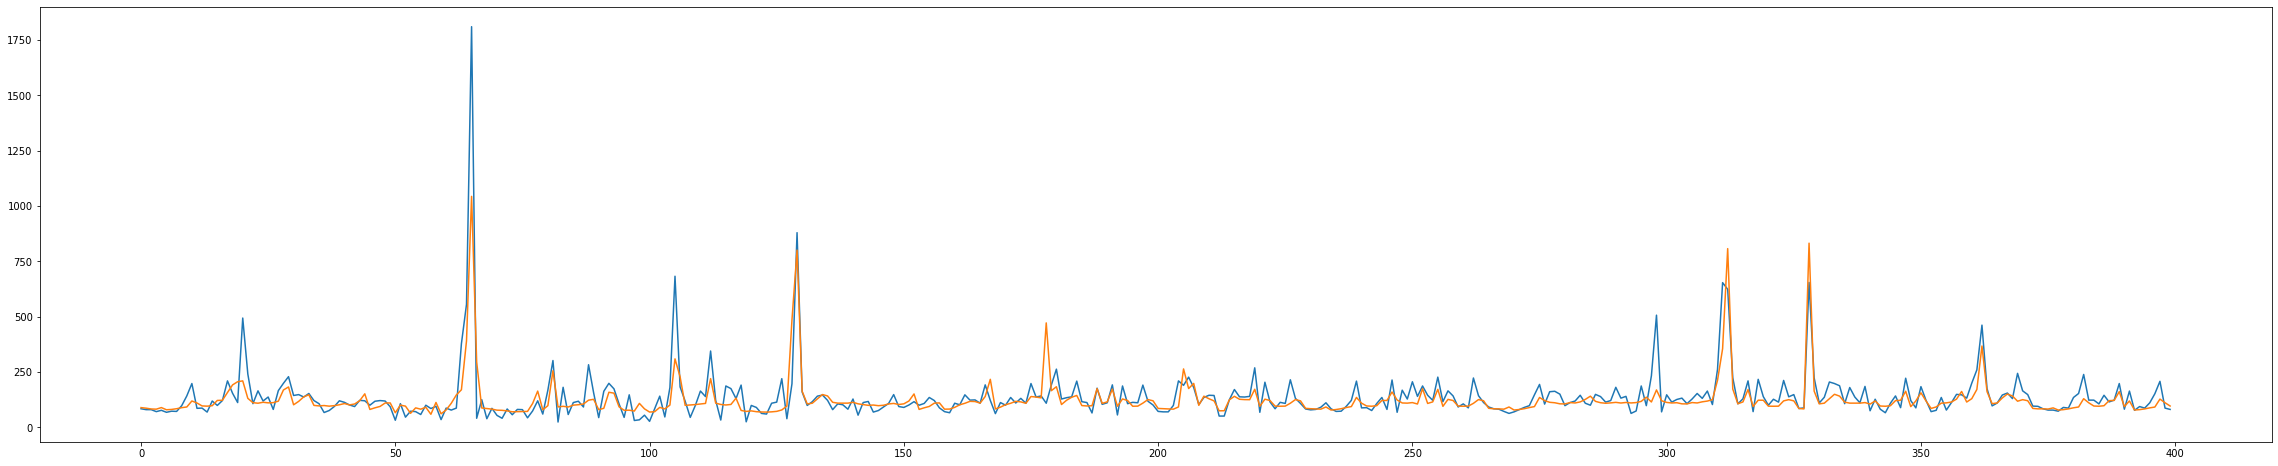

In [60]:
plt.figure(figsize=(40,8))
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_test[10000:10400])
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_pred[10000:10400])

In [62]:
#export model
model.save_weights('checkpoint/one_to_one.cpkt')

## LSTM Many To One : 3 time step window

In [12]:
train.columns

Index(['vehicle_id', 'line_id', 'datetime', 'station_id', 'vehicle_type',
       'sequence_id', 'order', 'line_label', 'datetime_diff', 'outlier',
       'hour', 'quarter', 'weekday', 'service_class', 'Temperature',
       'Precipitation', 'Wind Speed', 'Visibility', 'Cloud Cover',
       'Relative Humidity', 'Conditions', 'distance_diff',
       'distance_traveled'],
      dtype='object')

In [13]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

encoder = LabelEncoder()

encoder.fit(data[['line_label']])
train.line_label = encoder.transform(train.line_label)
test.line_label  = encoder.transform(test.line_label)

C:\Users\Aziz\Anaconda3\envs\transtu\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Aziz\Anaconda3\envs\transtu\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
train.drop(['outlier','datetime'], axis=1, inplace=True)
test.drop(['outlier','datetime'], axis=1, inplace=True)

C:\Users\Aziz\Anaconda3\envs\transtu\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
scaler = MinMaxScaler()
scaler_notarget = MinMaxScaler()

scaler.fit(train.drop(['sequence_id'], axis=1) )
scaler_notarget.fit(train.drop(['sequence_id','datetime_diff'], axis=1) );

In [16]:
train_input_X1 = scaler.transform(train.groupby('sequence_id',dropna=False).shift(2).fillna(-1))
train_input_X2 = scaler.transform(train.groupby('sequence_id',dropna=False).shift(1).fillna(-1))
train_input_X3 = scaler_notarget.transform(train.drop(['sequence_id', 'datetime_diff'], axis=1).fillna(-1))

In [17]:
test_input_X1 = scaler.transform(test.groupby('sequence_id',dropna=False).shift(2).fillna(-1))
test_input_X2 = scaler.transform(test.groupby('sequence_id',dropna=False).shift(1).fillna(-1))
test_input_X3 = scaler_notarget.transform(test.drop(['sequence_id', 'datetime_diff'], axis=1).fillna(-1))

In [18]:
y_train = train[['datetime_diff']].values
y_train.shape

(919349, 1)

In [19]:
y_test = test[['datetime_diff']].values
y_test.shape

(717310, 1)

In [20]:
#one time step
train_input_X1 = train_input_X1.reshape(-1,1,20)
train_input_X1.shape

(919349, 1, 20)

In [21]:
#two time steps
train_input_X2 = train_input_X2.reshape(-1,1,20)
train_input_X2.shape

(919349, 1, 20)

In [22]:
#three time steps
train_input_X3 = train_input_X3.reshape(-1,1,19)
train_input_X3.shape

(919349, 1, 19)

In [23]:
#one time step
test_input_X1 = test_input_X1.reshape(-1,1,20)
test_input_X1.shape

(717310, 1, 20)

In [24]:
test_input_X2 = test_input_X2.reshape(-1,1,20)
test_input_X2.shape

(717310, 1, 20)

In [25]:
test_input_X3 = test_input_X3.reshape(-1,1,19)
test_input_X3.shape

(717310, 1, 19)

In [26]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, RNN, GRU, LSTM, Dropout, concatenate, BatchNormalization, Multiply
from tensorflow.keras.losses import MAE, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

In [68]:
#model architecture keras API

#three time step inputs
time_step1 = Input(shape = (1,20))
time_step2 = Input(shape = (1,20))
time_step3 = Input(shape = (1,19))

#hidden standraizers layers
dense_ts1 = Dense(19, activation = 'relu')(time_step1)
dense_ts2 = Dense(19, activation = 'relu')(time_step2)
dense_ts3 = Dense(19, activation = 'relu')(time_step3)

#concatenate time step features in order
x  = concatenate([dense_ts1,dense_ts2,dense_ts3], axis = 1)

#Lstm / Gru / Rnn
x = LSTM(units = 124, activation='tanh' , input_shape = (-1, 3, 19), return_sequences=False)(x)

#Dense layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
out = Dense(1, activation='relu')(x)

In [69]:
model = Model([time_step1, time_step2,time_step3], out)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1, 20)]      0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 1, 20)]      0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 1, 19)]      0                                            
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 1, 19)        399         input_25[0][0]                   
____________________________________________________________________________________________

In [70]:
optimizer = Adam(lr=0.002)
loss = MeanSquaredError()
metric = RootMeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [71]:
#tensorflow data pipeline 
dataset = Dataset.from_tensor_slices(((train_input_X1, train_input_X2, train_input_X3), y_train))
dataset = dataset.batch(256)
train_data = dataset.prefetch(tf.data.experimental.AUTOTUNE)

dataset = Dataset.from_tensor_slices(((test_input_X1, test_input_X2, test_input_X3), y_test))
dataset = dataset.batch(256)
test_data = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
model.fit(train_data, validation_data = test_data, epochs=20 , shuffle=False , workers=4, use_multiprocessing=True,
          callbacks = EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 3, restore_best_weights=True)  )

Epoch 1/20
3592/3592 [==============================] - 61s 13ms/step - loss: 10967.4785 - root_mean_squared_error: 104.2455 - val_loss: 9195.5635 - val_root_mean_squared_error: 95.8935
Epoch 2/20
3592/3592 [==============================] - 46s 13ms/step - loss: 8315.7509 - root_mean_squared_error: 91.1000 - val_loss: 8316.3818 - val_root_mean_squared_error: 91.1942
Epoch 3/20
3592/3592 [==============================] - 59s 16ms/step - loss: 7314.4773 - root_mean_squared_error: 85.4539 - val_loss: 7227.8276 - val_root_mean_squared_error: 85.0166
Epoch 4/20
3592/3592 [==============================] - 57s 16ms/step - loss: 6521.9650 - root_mean_squared_error: 80.7154 - val_loss: 6647.6123 - val_root_mean_squared_error: 81.5329
Epoch 5/20
3592/3592 [==============================] - 57s 16ms/step - loss: 5866.5994 - root_mean_squared_error: 76.5632 - val_loss: 6434.5610 - val_root_mean_squared_error: 80.2157
Epoch 6/20
3592/3592 [==============================] - 59s 16ms/step - loss: 

In [ ]:
loss, rmse = model.evaluate(test_data)
print('test loss : {:.2f}    test rmse : {:.2f} '.format(loss, rmse))

In [49]:
#export model
model.save_weights('./checkpoint/Many_to_one.cpkt')

### Load Model

In [31]:
model.load_weights('./checkpoint/Many_to_one.cpkt')

### Confidence and prediction Intervals : 